# Cargo Holds:  Clean or Dirty?
___

### Transfer Learning

Not only because of the small dataset, but transfer learning is a worthwhile endeavor in of itself.  These pretrained models have been trained on extremely large and varied datasets.  They are adept at detecting patterns, layers, and complex features.  

The VGG16 model is available for this purpose through tensorflow.  Its architecture allows it to pick up general features in early laters before specializing in top layers, which is ideal for classification.  This makes for easy fine tuning for later layers, as the early layers can be frozen and the later layers fine tuned.

In this notebook the model will be imported, its top layers fine tuned, trained and tested.
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

In [2]:
# setup and freeze the base model top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the layers

In [3]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# create top layer for transfer model
trans_vgg16 = Sequential()
trans_vgg16.add(base_model)
trans_vgg16.add(Flatten())
trans_vgg16.add(Dense(1, activation='sigmoid'))

# compile
trans_vgg16.compile(optimizer='adam', loss='bce', metrics=['accuracy', 'AUC', Precision(), Recall()])

# architecture
trans_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
# create the image data generator to apply to the transformations to data
# the transformations are realistic as it relates to what could be seen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.8, 1.2),
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

validate_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Loading in image data
model_target_size = (224, 224)
model_batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '../data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

validation_generator = validate_datagen.flow_from_directory(
    '../data/validate/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

Found 1040 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [6]:
# add callbacks
checkpoint_path='../assets/saved_models/vgg16_models/'
checkpoint_vgg16 = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False)

checkpoint_vgg16_accuracy = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False)
checkpoint_vgg_16_recall = ModelCheckpoint(checkpoint_path + 'best_recall_model', monitor='val_recall', save_best_only=True, verbose=1, \
                                    save_weights_only=False, mode='max')
earlystopping_vgg16 = EarlyStopping(restore_best_weights=True, monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

# fit model
history_trans_vgg16 = trans_vgg16.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[earlystopping_vgg16, checkpoint_vgg16_accuracy, checkpoint_vgg_16_recall])

Epoch 1/25
33/33 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.6029 - auc: 0.6469 - precision: 0.6064 - recall: 0.5865
Epoch 1: val_accuracy improved from -inf to 0.73636, saving model to ../assets/saved_models/vgg16_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets



Epoch 1: val_recall improved from -inf to 0.60000, saving model to ../assets/saved_models/vgg16_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


33/33 [==============================] - 213s 6s/step - loss: 0.7898 - accuracy: 0.6029 - auc: 0.6469 - precision: 0.6064 - recall: 0.5865 - val_loss: 0.5339 - val_accuracy: 0.7364 - val_auc: 0.8212 - val_precision: 0.8250 - val_recall: 0.6000
Epoch 2/25
33/33 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.7510 - auc: 0.8435 - precision: 0.7476 - recall: 0.7577
Epoch 2: val_accuracy improved from 0.73636 to 0.77273, saving model to ../assets/saved_models/vgg16_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets



Epoch 2: val_recall improved from 0.60000 to 0.80000, saving model to ../assets/saved_models/vgg16_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


33/33 [==============================] - 216s 7s/step - loss: 0.4895 - accuracy: 0.7510 - auc: 0.8435 - precision: 0.7476 - recall: 0.7577 - val_loss: 0.4885 - val_accuracy: 0.7727 - val_auc: 0.8476 - val_precision: 0.7586 - val_recall: 0.8000
Epoch 3/25
33/33 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.7942 - auc: 0.8828 - precision: 0.8122 - recall: 0.7654
Epoch 3: val_accuracy improved from 0.77273 to 0.80000, saving model to ../assets/saved_models/vgg16_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets



Epoch 3: val_recall did not improve from 0.80000
33/33 [==============================] - 203s 6s/step - loss: 0.4304 - accuracy: 0.7942 - auc: 0.8828 - precision: 0.8122 - recall: 0.7654 - val_loss: 0.4600 - val_accuracy: 0.8000 - val_auc: 0.8653 - val_precision: 0.8113 - val_recall: 0.7818
Epoch 4/25
33/33 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8106 - auc: 0.8973 - precision: 0.8088 - recall: 0.8135
Epoch 4: val_accuracy did not improve from 0.80000

Epoch 4: val_recall did not improve from 0.80000
33/33 [==============================] - 187s 6s/step - loss: 0.4106 - accuracy: 0.8106 - auc: 0.8973 - precision: 0.8088 - recall: 0.8135 - val_loss: 0.4599 - val_accuracy: 0.7818 - val_auc: 0.8635 - val_precision: 0.7925 - val_recall: 0.7636
Epoch 5/25
33/33 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8452 - auc: 0.9291 - precision: 0.8527 - recall: 0.8346
Epoch 5: val_accuracy improved from 0.80000 to 0.81818, saving model to

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets



Epoch 5: val_recall did not improve from 0.80000
33/33 [==============================] - 198s 6s/step - loss: 0.3515 - accuracy: 0.8452 - auc: 0.9291 - precision: 0.8527 - recall: 0.8346 - val_loss: 0.4553 - val_accuracy: 0.8182 - val_auc: 0.8701 - val_precision: 0.8723 - val_recall: 0.7455
Epoch 6/25
33/33 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8404 - auc: 0.9260 - precision: 0.8540 - recall: 0.8212
Epoch 6: val_accuracy did not improve from 0.81818

Epoch 6: val_recall did not improve from 0.80000
33/33 [==============================] - 193s 6s/step - loss: 0.3552 - accuracy: 0.8404 - auc: 0.9260 - precision: 0.8540 - recall: 0.8212 - val_loss: 0.4778 - val_accuracy: 0.7818 - val_auc: 0.8617 - val_precision: 0.8605 - val_recall: 0.6727
Epoch 7/25
33/33 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8538 - auc: 0.9405 - precision: 0.8608 - recall: 0.8442
Epoch 7: val_accuracy did not improve from 0.81818

Epoch 7: val_recall

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


33/33 [==============================] - 201s 6s/step - loss: 0.3168 - accuracy: 0.8712 - auc: 0.9443 - precision: 0.8876 - recall: 0.8500 - val_loss: 0.4490 - val_accuracy: 0.7727 - val_auc: 0.8702 - val_precision: 0.7500 - val_recall: 0.8182
Epoch 9/25
33/33 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8731 - auc: 0.9475 - precision: 0.8702 - recall: 0.8769
Epoch 9: val_accuracy did not improve from 0.81818

Epoch 9: val_recall improved from 0.81818 to 0.87273, saving model to ../assets/saved_models/vgg16_models\best_recall_model


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


33/33 [==============================] - 199s 6s/step - loss: 0.3072 - accuracy: 0.8731 - auc: 0.9475 - precision: 0.8702 - recall: 0.8769 - val_loss: 0.4429 - val_accuracy: 0.7727 - val_auc: 0.8795 - val_precision: 0.7273 - val_recall: 0.8727
Epoch 10/25
33/33 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8750 - auc: 0.9491 - precision: 0.8854 - recall: 0.8615
Epoch 10: val_accuracy did not improve from 0.81818

Epoch 10: val_recall did not improve from 0.87273
33/33 [==============================] - 194s 6s/step - loss: 0.2969 - accuracy: 0.8750 - auc: 0.9491 - precision: 0.8854 - recall: 0.8615 - val_loss: 0.4299 - val_accuracy: 0.8091 - val_auc: 0.8845 - val_precision: 0.8036 - val_recall: 0.8182
Epoch 11/25
33/33 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.8952 - auc: 0.9600 - precision: 0.8944 - recall: 0.8962
Epoch 11: val_accuracy did not improve from 0.81818

Epoch 11: val_recall did not improve from 0.87273
33/33 [=======

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\best_recall_model\assets


33/33 [==============================] - 193s 6s/step - loss: 0.2722 - accuracy: 0.8808 - auc: 0.9568 - precision: 0.8882 - recall: 0.8712 - val_loss: 0.4860 - val_accuracy: 0.7636 - val_auc: 0.8838 - val_precision: 0.7042 - val_recall: 0.9091
Epoch 14/25
33/33 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8808 - auc: 0.9480 - precision: 0.8837 - recall: 0.8769
Epoch 14: val_accuracy did not improve from 0.81818

Epoch 14: val_recall did not improve from 0.90909
33/33 [==============================] - 188s 6s/step - loss: 0.2930 - accuracy: 0.8808 - auc: 0.9480 - precision: 0.8837 - recall: 0.8769 - val_loss: 0.4778 - val_accuracy: 0.7636 - val_auc: 0.8712 - val_precision: 0.8222 - val_recall: 0.6727
Epoch 15/25
33/33 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.8923 - auc: 0.9627 - precision: 0.9096 - recall: 0.8712
Epoch 15: val_accuracy did not improve from 0.81818

Epoch 15: val_recall did not improve from 0.90909
33/33 [=======

In [8]:
trans_vgg16.save('../assets/saved_models/vgg16_models/not_good_model')

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models/not_good_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models/not_good_model\assets


___
### Model Evaluation

As before, let's see how the model does on the test set and evaluate its metrics
___

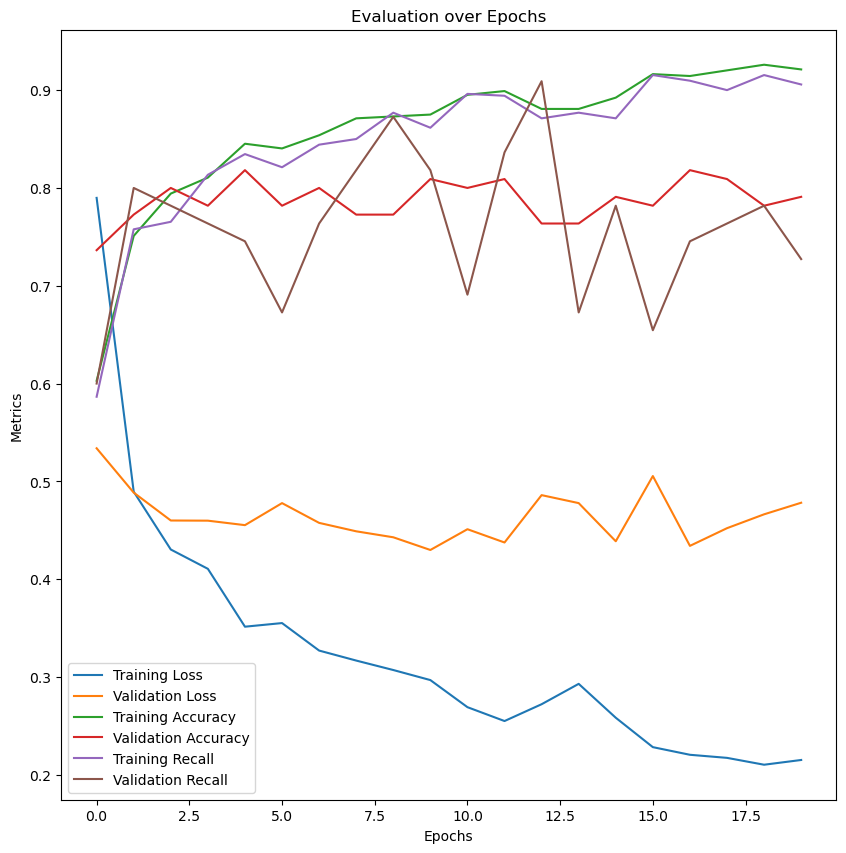

In [10]:
# plotting the training and validation metrics over epochs
plt.figure(figsize=(10,10))
plt.plot(history_trans_vgg16.history['loss'], label='Training Loss', )
plt.plot(history_trans_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_trans_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_trans_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_trans_vgg16.history['recall'], label='Training Recall')
plt.plot(history_trans_vgg16.history['val_recall'], label='Validation Recall')
plt.title('Evaluation over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [11]:
# feed the test dataset to the model to generate predictions
test_datagen = ImageDataGenerator(
    rescale=1./255 # This is a necessary preprocessing step
)
test_generator = test_datagen.flow_from_directory(
    '../data/test/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode=None,
    shuffle=False
)

print(test_generator.class_indices)

Found 110 images belonging to 2 classes.
{'clean': 0, 'dirty': 1}


In [13]:
# make predictions
predictions = trans_vgg16.predict(test_generator, verbose=1)
predicted_class = (predictions > 0.5).astype(int)
class_labels = test_generator.classes
image_names = test_generator.filenames

# print image name and prediction
for image, pred_class in enumerate(predicted_class):
    print(f'Image {image_names[image]} predicted as class: {pred_class}')

4/4 [==============================] - 22s 4s/step
Image clean\12c943_52556a070d844543b57583b7291c93a5~mv2.jpg predicted as class: [0]
Image clean\1519ac76-9cfd-47f0-bf77-5dc3a1147adc.jpg predicted as class: [0]
Image clean\1f761525-88f0-4260-93f5-e54363e0a015.jpg predicted as class: [0]
Image clean\1fa83d4b-9b3b-4be9-abd2-fdd04c09a3e2.jpg predicted as class: [0]
Image clean\27d568c2-6951-4792-b1a8-d7f302bc7675.jpg predicted as class: [0]
Image clean\298de5fc-414c-4c7e-a023-d3651e001672.jpg predicted as class: [0]
Image clean\30799286-fc80-4789-9601-d7d9e6cc20c8.jpg predicted as class: [0]
Image clean\3325c33c-1417-4378-8068-31838ac99b3c.jpg predicted as class: [0]
Image clean\3ed7e6fc-84ec-48ec-b594-12a8f8a7cf5b.jpg predicted as class: [1]
Image clean\44765f2b-2795-4b74-ba89-94284f4f532d.jpg predicted as class: [1]
Image clean\46474608_1983203988393520_7337535301151096832_n.jpg predicted as class: [1]
Image clean\46624108_1983204011726851_8909396883701497856_n.jpg predicted as class: 

Precision score: 0.84.
Recall score: 0.87.
F1 score: 0.86.


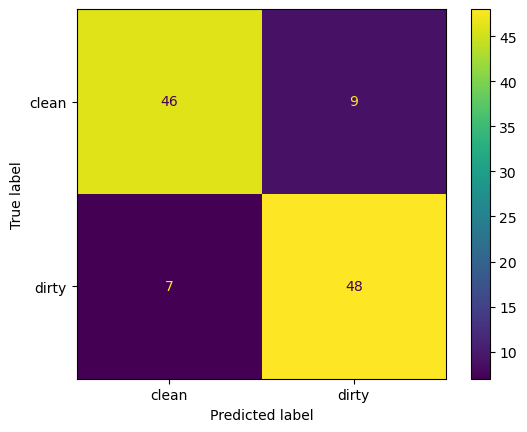

In [14]:
# evaluation metrics
precision = precision_score(class_labels, predicted_class)
recall = recall_score(class_labels, predicted_class)
f1_result = f1_score(class_labels, predicted_class)
confusing_matrix = confusion_matrix(class_labels, predicted_class)

print(f'Precision score: {round(precision, 2)}.')
print(f'Recall score: {round(recall, 2)}.')
print(f'F1 score: {round(f1_result, 2)}.')

cmd = ConfusionMatrixDisplay(confusion_matrix=confusing_matrix, display_labels=test_generator.class_indices)
cmd.plot();

In [15]:
# list of false negatives
false_negatives = []
print('False Negatives')
for image, pred_class in enumerate(predicted_class):
    if pred_class == 0:
        if pred_class != class_labels[image]:
            false_negatives.append(image_names[image])
            print(f'Image {image_names[image]} predicted class "clean" but labeled "dirty".')

False Negatives
Image dirty\0c107874-1545-411e-9302-5faafbe610fd.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_6e5e6bce798c4a79bdfe21b92be8e822~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_b20de859cd0d47e397446cbbcec30f16~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_d95ecb50bf9147aeb5401518c594378a~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\50872917_2076377809076137_2151994965683601408_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\84946351_2757372924309952_2201818991498887168_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\IMG-20241014-WA0077.jpg predicted class "clean" but labeled "dirty".


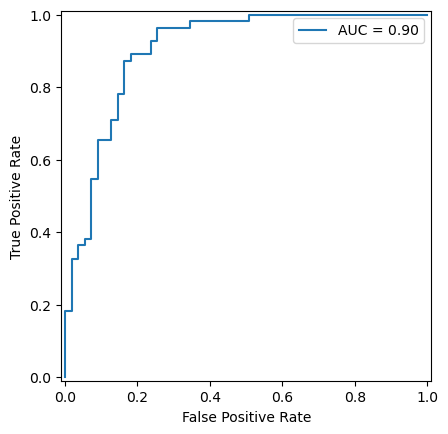

In [16]:
# Check the ROC Curve - will help us see how well the model is defining classes
fpr, tpr, thresholds = roc_curve(class_labels, predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.legend()
plt.show;

In [17]:
# generate the roc_auc_score
roc_auc_score = round(roc_auc_score(class_labels, predictions), 4)
roc_auc_score

0.9041

___
### Model Evaluation  
  

___
##### Overfitting or Underfitting
The VGG16 based model did have some oscilattions with the validation recall.  The model did show some signs of overfitting or underfitting.  There was a noticeable difference developping between the training and testing accuarcy for the model stopped.  The validation loss appears to plateau before oscillating.  The model did ok on the test set, but landed right between the training 92% and the validation set 79%.  This could suggest that the model responding well to the validation set.  This could be a consequence of the dataset size.

The most obvious sign of underfitting, not performing well on training or validation accuaracy, this was not the case.  The training and validation set accuracy was still well beyond 50%.  The training loss was falling, while the validation loss plateaued early.

The model is likely too complex for the dataset and so overfitting.
___
##### Predictions and Confusion Matrix

This model also has a strong recall at 87%, with similar precision and F1 scores.  This model got ten more true negatives right while reducing false positives by the same amount.  The model is fairly balanced and accurate, though does appear overfit. 

True Negatives = 46 (correctly predicted clean)
False Negatives = 7 (wrongly predicted clean)
False Positves = 9 (wrongly predicted dirty)
True Positives = 48 (correctly predicted dirty)
___
##### ROC AUC Curve
As mentioned earlier, 1.00 is the ideal score and 0.5 is bottom score.  A score of 0.75 would be average.  The model scored 0.90 which is strong.  It is distinguishing the classes fairly well, but this could be a result of having learned this data too well.  The model stopped early after getting similar accuracy levels as the simple CNN model.  This is strong evidence of overfitting to a small dataset.

___
### Conclusions

This is strong evidence that the dataset is simply too small.  A complex and deep CNN model was overfitting to the data while a simple CNN was obtaining similar results without signs of overfitting.  So in short, it was not performing better.

This leaves the question unanswered in regard to data selection.  This will play a part in the next steps as this project shifts from a binary classification problem to a multiclass with the acquistion of more data.

Even so, there are still enough warning flags not to place too much confidence in the simple CNN model for now.  
* The dataset is too small, there is a significant portion of synthetic data.
* The images were classified with a mindset to accept more data until the dataset grows.  This mindset has resulted in more obvious images being included.
* Tell tales were not scrubbed out, leaving potential data leakage with such a large portion of synthetic data.
* The creation of synthetic data, could also invariably shift an image from one class to the other, if it excludes the dirty portion and magnifies the clean portion of an image.

All in all, the model does show promise.  The false predictions were on edge cases and even one image intentionally planted (a clean image put in a dirty directory).  If given a larger dataset the model seems to be able to grow with it to provide a tool that will provide predictions with associated probabilities that the image meets a class.
___